In [1]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.cm as cm
from utils.utils import make_matching_plot_fast,process_resize,frame2tensor,VideoStreamer
import matplotlib.pyplot as plt
import numpy as np
import torch
%matplotlib inline

In [2]:
#constants
CONFIDENCE_THRESHOLD = 0.1
# Minimum probability value to accept a detected instance
# ROIs below this threshold are skipped
DETECTION_MIN_CONFIDENCE = 0.8

# Non-maximum suppression threshold for detection
DETECTION_NMS_THRESHOLD = 0.3

## 1.keypoints detection(LoFTR)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    raise RuntimeError("GPU is required to run this demo.")

def keypoint_detection(img0,img1,device):
    
    conf_threshold = CONFIDENCE_THRESHOLD
    img0_tensor = frame2tensor(img0,device)
    img1_tensor = frame2tensor(img1,device)
    data = {'image0': img0_tensor, 'image1': img1_tensor}
    
    matcher = KF.LoFTR(pretrained='indoor_new').eval().to(device=device)
    
    with torch.inference_mode():
        correspondences = matcher(data)
        
    total_n_matches = len(correspondences['keypoints0'])
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    mconf = correspondences['confidence'].cpu().numpy()
    
    ind = mconf> conf_threshold
    total_n_matches = ind.sum()
    mkpts0 = mkpts0[ind]
    mkpts1 = mkpts1[ind]
    mconf = mconf[ind]
    
    return total_n_matches,mkpts0,mkpts1,mconf

## 2. Compute F_mat here; Test the result in step 5
       (K R t are from the calibration file.)

In [4]:
# cam0 = {
#     "K": torch.tensor([[1399.965713 * scale_x, 0.0, 943.129998 * scale_x],
#                         [0.0, 1394.609791 * scale_y, 554.244042 * scale_y],
#                         [0.0, 0.0, 1.0]]),
#     "R": torch.tensor([[-0.6456051742, 0.03473953627, 0.7628808057],
#                        [0.09040156866, 0.9954173139, 0.03117575436],
#                        [-0.7583017311, 0.08909284986, -0.6457870769]]),
#     "t": torch.tensor([[20.06419515],
#                        [126.2317869],
#                        [289.6604271]])
# }
# 
# cam1 = {
#     "K": torch.tensor([[1397.07023 * scale_x, 0.0, 936.040984 * scale_x],
#                         [0.0, 1392.579762 * scale_y, 561.303222 * scale_y],
#                         [0.0, 0.0, 1.0]]),
#     "R": torch.tensor([[-0.2919319768, -0.05002387035, 0.9551300086],
#                        [0.4259049826, 0.8873553584, 0.1766505412],
#                        [-0.8563764748, 0.4583645714, -0.2377419883]]),
#     "t": torch.tensor([[-13.59650874],
#                        [95.12428493],
#                        [337.6892886]])
# }

In [5]:
import torch

scale_x = 640 / 1920
scale_y = 480 / 1080
cam0 = {
    "K": torch.tensor([[1395.91 * scale_x, 0.0, 951.559 * scale_x],
                       [0.0, 1392.24 * scale_y, 561.398 * scale_y],
                       [0.0, 0.0, 1.0]]),
    "R": torch.tensor([[0.05337497606, 0.02479711619, 0.9982666052],
                       [0.6376765256, 0.7684660834, -0.05318390075],
                       [-0.7684528356, 0.6394098699, 0.0252043199]]),
    "t": torch.tensor([[6.299256813],
                       [104.397182],
                       [363.078698]])
}
cam1 = {
    "K": torch.tensor([[1633.26 * scale_x, 0.0, 949.479 * scale_x],
                       [0.0, 1629.32 * scale_y , 572.374 * scale_y],
                       [0.0, 0.0, 1.0]]),
    "R": torch.tensor([[-0.5292732399, -0.01229259603, 0.8483623811],
                       [0.636650989, 0.6551966806, 0.4066851706],
                       [-0.5608434325, 0.7553583268, -0.3389519765]]),
    "t": torch.tensor([[-5.411400695],
                       [80.12176746],
                       [379.8488129]])
}

K0, K1 = cam0["K"], cam1["K"]
R0, R1 = cam0["R"], cam1["R"]
t0, t1 = cam0["t"], cam1["t"]

E_mat = K.geometry.epipolar.essential_from_Rt(R0, t0, R1, t1)
F_mat = K.geometry.epipolar.fundamental_from_essential(E_mat, K0, K1)

print("Fundamental matrix: \n", F_mat)

Fundamental matrix: 
 tensor([[-5.9504e-05, -6.9686e-05,  4.9947e-02],
        [-5.8388e-05,  4.1050e-05,  1.7744e-01],
        [-9.7330e-02, -1.5972e-01,  2.8025e+01]])


## 3. Video to frames and Select frames

==> Processing video input: /home/jireh/MT/data/hdVideos/hd_00_01.mp4
==> Processing video input: /home/jireh/MT/data/hdVideos/hd_00_04.mp4


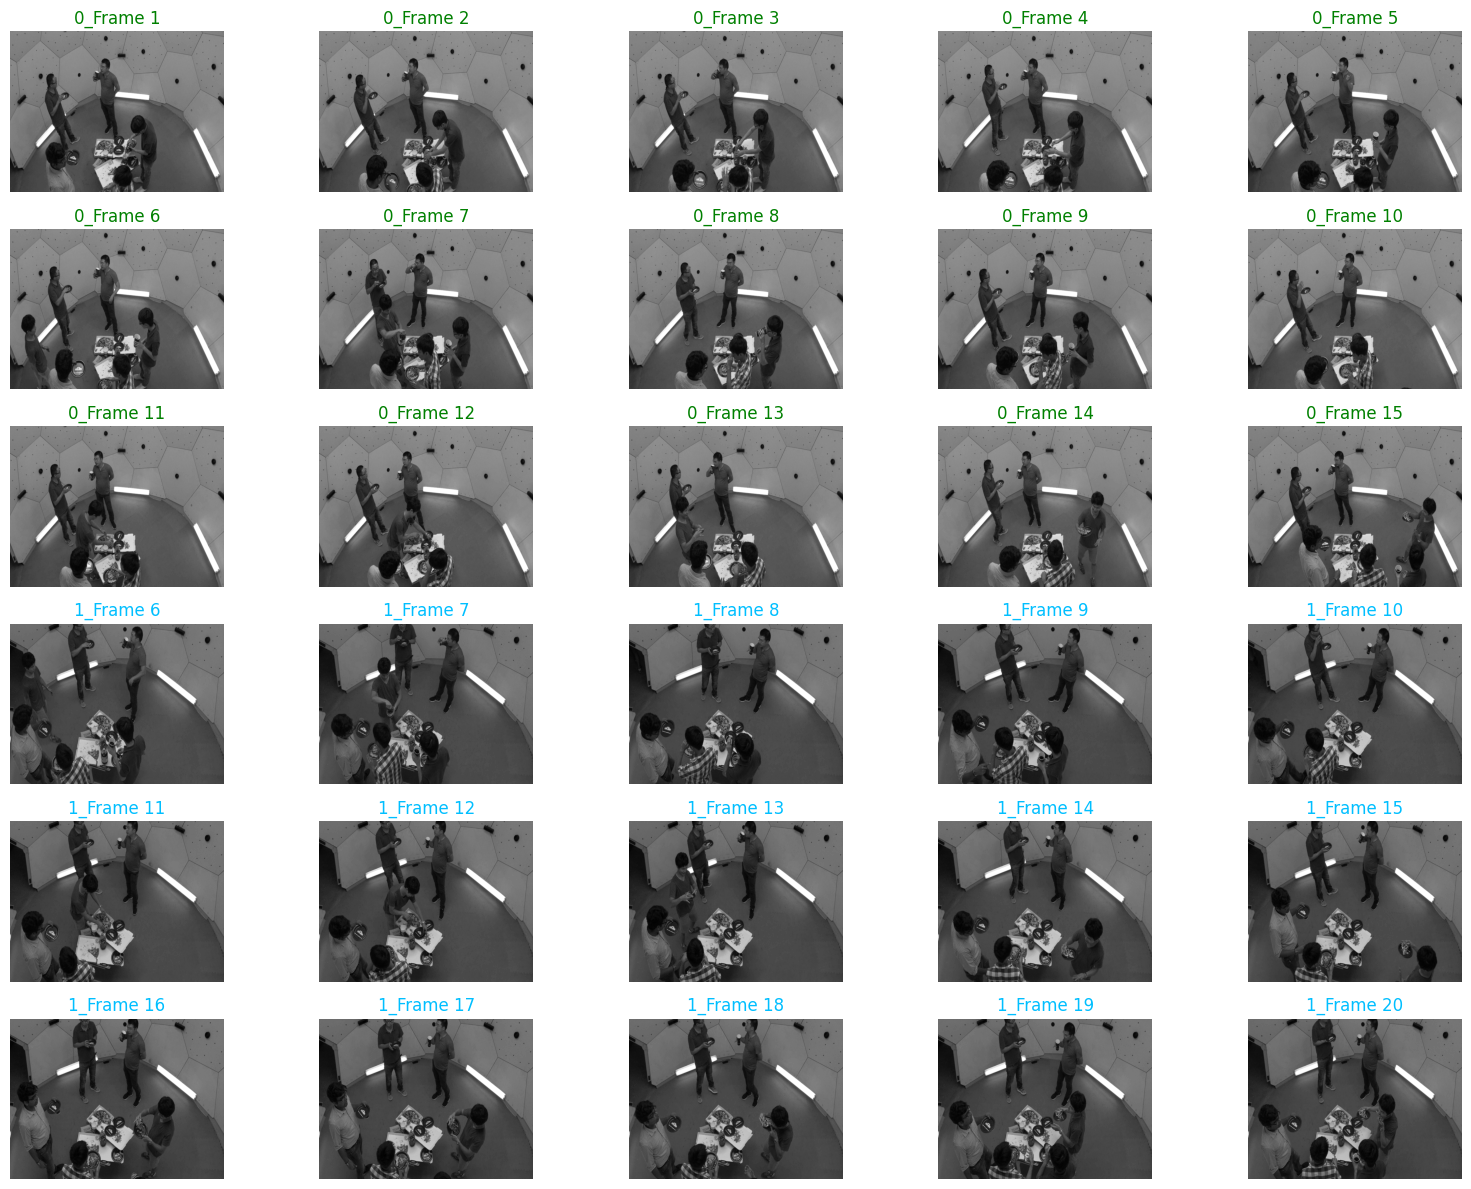

In [6]:
video_input0 = "/home/jireh/MT/data/hdVideos/hd_00_01.mp4"
video_input1 = "/home/jireh/MT/data/hdVideos/hd_00_04.mp4"
skip = 100
max_length = 100000

vs0 = VideoStreamer(video_input0, [640, 480], skip,max_length)
vs1 = VideoStreamer(video_input1, [640, 480], skip,max_length)

fig,axes = plt.subplots(6,5,figsize = (16,12))
for _ in range(10):
    frame0, ret0 = vs0.next_frame()
    frame1, ret1 = vs1.next_frame()
    
frame_set0 = []
frame_set1 = []
for i in range(3):
    for j in range(5):
        frame, ret = vs0.next_frame()
        assert ret, 'Error when reading the first frame (try different --input?)'
        axes[i,j].imshow(frame,cmap='gray')
        axes[i, j].axis('off')  
        axes[i, j].set_title(f"0_Frame {i*5+j+1}",color='green')
        frame_set0.append(frame)

#video1 shift 5 frames
for _ in range(5):
    frame, ret = vs1.next_frame()

for i in range(3):
    for j in range(5):
        frame, ret = vs1.next_frame()
        assert ret, 'Error when reading the first frame (try different --input?)'
        axes[i+3,j].imshow(frame,cmap='gray')
        axes[i+3, j].axis('off')  
        axes[i+3, j].set_title(f"1_Frame {i*5+j+6}",color='deepskyblue')
        frame_set1.append(frame)

plt.tight_layout()
plt.savefig("Frame.png")
plt.show()

## 4.Background mask

In [7]:
import cv2
import numpy as np
import os
import sys
from utils.samples.coco import coco
from mrcnn import utils
from mrcnn import model as modellib
from mrcnn import visualize
import matplotlib.pyplot as plt
import PIL.Image
import sys

Using TensorFlow backend.


In [8]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [9]:
def loadMRCNN():
    # Load the pre-trained model data
    ROOT_DIR = os.getcwd()
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        # Minimum probability value to accept a detected instance
        # ROIs below this threshold are skipped
        DETECTION_MIN_CONFIDENCE = DETECTION_MIN_CONFIDENCE 

        # Non-maximum suppression threshold for detection
        DETECTION_NMS_THRESHOLD = DETECTION_NMS_THRESHOLD
        IMAGES_PER_GPU = 1

    config = InferenceConfig()

    # COCO dataset object names
    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)

    return model

def segment(image, r):
    # Create an empty mask for all objects
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    # Loop through all detected masks and add them to the combined mask
    for i in range(r['masks'].shape[2]):
        mask += r['masks'][:, :, i].astype(np.uint8)
    # Convert the mask to a binary mask (0 for background, 1 for objects)
    mask_bg = (mask > 0).astype(np.uint8)
    # Create a 3-channel mask for blending
    mask = np.stack((mask_bg,) * 3, axis=-1)
    # Create a background mask (complement of the object mask)
    bg_mask = 1 - mask
    # Apply the object mask to the original image
    mask_img = image * mask
    # Create a background image (white background)
    bg = np.ones_like(image) * 255
    # Combine the object image and background image
    result = mask_img + bg * bg_mask
    return result,mask_bg

def maskBg(image):
    model = loadMRCNN()
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    # Run detection
    results = model.detect([image], verbose=0)

    # Visualize results
    r = results[0]
    # visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
    #                             class_names, r['scores'])

    segmentation,mask_bg = segment(image, r)
    
    # Visualize the result
    # plt.subplots(1, figsize=(16, 16))
    # plt.axis('off')
    # plt.imshow(np.concatenate([image, segmentation], axis=1))

    # print("mask_bg shape: ", mask_bg.shape, "\n", "num of object pixels: ", mask_bg.sum())
    
    return mask_bg

## 5. To verify the LoFTR and visualize the matching results





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.





2023-09-27 09:48:16.857126: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-09-27 09:48:16.880704: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2599990000 Hz
2023-09-27 09:48:16.881298: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1bb54fa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-27 09:48:16.881319: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-09-27 09:48:16.882639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-09-27 09:48:16.984089: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-27 09:48:16.984332: I te

/home/jireh/anaconda3/envs/MT/lib/python3.7/site-packages/kornia/feature/loftr/utils/coarse_matching.py:256: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  mkpts0_c = torch.stack([i_ids % data['hw0_c'][1], i_ids // data['hw0_c'][1]], dim=1) * scale0
/home/jireh/anaconda3/envs/MT/lib/python3.7/site-packages/kornia/feature/loftr/utils/coarse_matching.py:257: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for a

after removing background: 32 points left


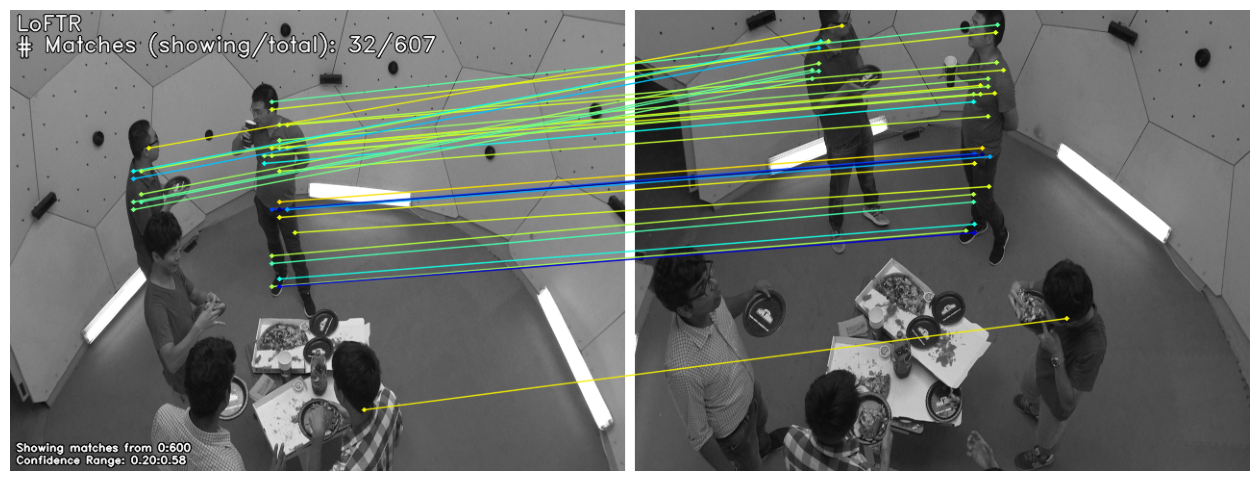

In [10]:
#Create a window to display the demo.
# window_name = 'LoFTR Matches'
# cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
# cv2.resizeWindow(window_name, (640 * 2, 480))
%matplotlib inline

img0 = frame_set0[12]
img1 = frame_set1[12]
mask_bg = maskBg(img0)
total_n_matches,mkpts0,mkpts1,mconf = keypoint_detection(img0,img1,device)
#using background mask to remove the background
# for mkpt0,mkpt1 in zip(mkpts0,mkpts1):
#     if mask_bg[int(mkpt0[1]),int(mkpt0[0])] == 0:
#         mkpts0 = np.delete(mkpts0,np.where(mkpts0==mkpt0)[0],axis=0)
#         mkpts1 = np.delete(mkpts1,np.where(mkpts1==mkpt1)[0],axis=0)
#         mconf = np.delete(mconf,np.where(mconf==mconf)[0],axis=0)
# print(f"after removing background: {len(mkpts0)} points left")
idx = []
for i in range(len(mkpts0)):
    x,y = mkpts0[i]
    if mask_bg[int(y)][int(x)] == 1:
        idx.append(i)
mkpts0 = mkpts0[idx]
mkpts1 = mkpts1[idx]
mconf = mconf[idx]

print(f"after removing background: {len(mkpts0)} points left")

vis_range = [0,600]
#how many points wanna show?
mkpts0 = mkpts0[vis_range[0]:vis_range[1]]
mkpts1 = mkpts1[vis_range[0]:vis_range[1]]
mconf = mconf[vis_range[0]:vis_range[1]]

# Normalize confidence.
if len(mconf) > 0:
    conf_vis_min = 0.
    conf_min = mconf.min()
    conf_max = mconf.max()
    mconf = (mconf - conf_vis_min) / (conf_max - conf_vis_min + 1e-5)

#Low values map to blue, medium values map to green, and high values map to red.
alpha = 0
color = cm.jet(mconf, alpha=alpha) 
text = [
    f'LoFTR',
    '# Matches (showing/total): {}/{}'.format(len(mkpts0), total_n_matches),
]
small_text = [
    f'Showing matches from {vis_range[0]}:{vis_range[1]}',
    f'Confidence Range: {conf_min:.2f}:{conf_max:.2f}',
]
out = make_matching_plot_fast(
    img0, img1, mkpts0, mkpts1, mkpts0, mkpts1, color, text,
    path=None, show_keypoints=False, small_text=small_text)

# cv2.imshow('LoFTR Matches', out)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.figure(figsize=(16,12))
plt.imshow(out)
plt.axis('off')  
plt.show()

## 6. To verify the F_mat:draw epipolar lines on img1 and corresponding points on img0. But it seems not right.

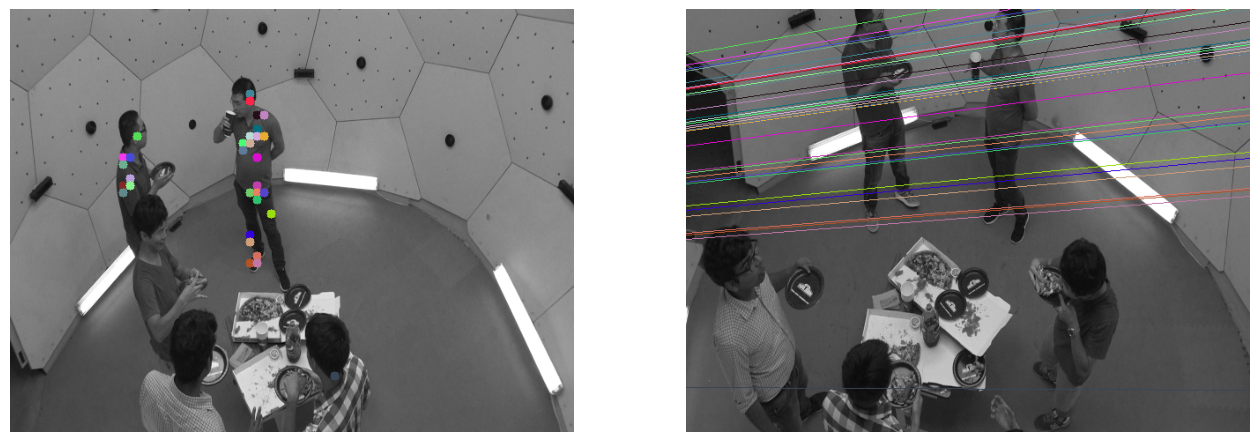

In [11]:
img0 = cv2.cvtColor(img0, cv2.COLOR_GRAY2BGR)
img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)

def draw_epilines(image1,points,image2,Fm):
    """
    For verifing Fm.
    Draw epilines on image2 and corresponding points on image1.
    """
    lines2 = cv2.computeCorrespondEpilines(mkpts0, 1, Fm)
    lines2 = lines2.reshape(-1, 3)

    for r, pt in zip(lines2, points):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [image2.shape[1], -(r[2]+r[0]*image2.shape[1])/r[1]])
        image1 = cv2.circle(image1, tuple(map(int, pt)), 5, color, -1)
        image2 = cv2.line(image2, (x0, y0), (x1, y1), color, 1)
    return image1, image2

def visualize_epipolarline(image1,points,image2,Fm):
    image1_with_points, image2_with_lines = draw_epilines(image1, mkpts0[:100], image2, Fm)
    plt.figure(figsize=(16,8))
    plt.subplot(121)
    plt.imshow(image1_with_points)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(image2_with_lines)
    plt.axis('off')
    plt.show()
    
visualize_epipolarline(img0,mkpts0,img1,np.array(F_mat))

## 7. compute distance(or num of inliers)

In [12]:
def MaskIndex(mkpts0,mask_bg):
    idx = []
    for i in range(len(mkpts0)):
        x,y = mkpts0[i]
        if (mask_bg[int(y)][int(x)] == 1):
            idx.append(i)
    return np.array(idx)
def bgRemoval(mkpts0,mkpts1,mconf,idx):
    if len(idx) == 0:
        return 0,[],[],[]
    else:
        mkpts0 = mkpts0[idx]
        mkpts1 = mkpts1[idx]
        mconf = mconf[idx]
        return len(idx),mkpts0,mkpts1,mconf

In [13]:
#for selected frame in video0 each frame in video1
import time
# index_f0 = 13 #6-15  (13,17)
match_frame1 = 0
min_distance = 100000
# frame0 = frame_set0[index_f0-1]
for j,frame0 in enumerate(frame_set0[5:]):
    start = time.time()
    mask_bg = maskBg(frame0)
    print(f"______________________________ Begin matching with 0_Frame {j+6} _________________________________")
    # print(f"Mask computation for 0_Frame {j+6} finished ...")
    min_distance = 100000
    for i,frame1 in enumerate(frame_set1):
        total_n_matches,mkpts0,mkpts1,mconf = keypoint_detection(frame0,frame1,device)
        mask_idx = MaskIndex(mkpts0,mask_bg)
        #Background removal
        total_n_matches,mkpts0,mkpts1,mconf = bgRemoval(mkpts0,mkpts1,mconf,mask_idx)
        
        if len(mkpts0) == 0 or len(mkpts1) ==0:
            distances = 100000
        else:
            F_mat= torch.Tensor(F_mat.reshape(-1, 3, 3))
            F_mat= F_mat.to(device)
            distances = K.geometry.epipolar.sampson_epipolar_distance(torch.tensor(mkpts0).to(device), torch.tensor(mkpts1).to(device), F_mat, squared=True, eps=1e-08)
            distances = distances.mean()
        if distances < min_distance:
            min_distance = distances
            match_frame1 = i+6
        # print(f"Matching distances between 0_Frame {j+6} and 1_Frame {i+6}:{distances}; in total:{total_n_matches} matched points")
    end = time.time()
    print(f" Result: 0_Frame {j+6} corresponds to 1_Frame {match_frame1} with distance {min_distance}, time cost:{end-start}")
    if j+6 != match_frame1:
        print(f"False match !")

______________________________ Begin matching with 0_Frame 6 _________________________________
 Result: 0_Frame 6 corresponds to 1_Frame 6 with distance 3.0980064868927, time cost:20.470900058746338
______________________________ Begin matching with 0_Frame 7 _________________________________
 Result: 0_Frame 7 corresponds to 1_Frame 7 with distance 10.830032348632812, time cost:20.11574935913086
______________________________ Begin matching with 0_Frame 8 _________________________________
 Result: 0_Frame 8 corresponds to 1_Frame 8 with distance 2.5542829036712646, time cost:21.115919589996338
______________________________ Begin matching with 0_Frame 9 _________________________________
 Result: 0_Frame 9 corresponds to 1_Frame 9 with distance 5.190464496612549, time cost:20.19678020477295
______________________________ Begin matching with 0_Frame 10 _________________________________
 Result: 0_Frame 10 corresponds to 1_Frame 10 with distance 3.426812171936035, time cost:21.1825597286

Result: 0_Frame 13 corresponds to 1_Frame 18 with distance 4.683427333831787, time cost:24.177489519119263

## Draft below

In [14]:
# # Load the pre-trained model data
# ROOT_DIR = os.getcwd()
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# if not os.path.exists(COCO_MODEL_PATH):
#     utils.download_trained_weights(COCO_MODEL_PATH)
#     
# class InferenceConfig(coco.CocoConfig):
#     GPU_COUNT = 1
#     # Minimum probability value to accept a detected instance
#     # ROIs below this threshold are skipped
#     DETECTION_MIN_CONFIDENCE = 0.8
# 
#     # Non-maximum suppression threshold for detection
#     DETECTION_NMS_THRESHOLD = 0.3
#     IMAGES_PER_GPU = 1
#     
# config = InferenceConfig()
# 
# # COCO dataset object names
# model = modellib.MaskRCNN(
#     mode="inference", model_dir=MODEL_DIR, config=config
# )
# model.load_weights(COCO_MODEL_PATH, by_name=True)
# 
# # COCO Class names
# # Index of the class in the list is its ID. For example, to get ID of
# # the teddy bear class, use: class_names.index('teddy bear')
# class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                'bus', 'train', 'truck', 'boat', 'traffic light',
#                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#                'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#                'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#                'kite', 'baseball bat', 'baseball glove', 'skateboard',
#                'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#                'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#                'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#                'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#                'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#                'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#                'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#                'teddy bear', 'hair drier', 'toothbrush']
# 
# # image = cv2.imread("../data/test2.png")
# # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = frame_set0[12]
# image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
# # Run detection
# results = model.detect([image], verbose=0)
# 
# # Visualize results
# r = results[0]
# visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'])
# 
# def segment(image, r):
#     # Create an empty mask for all objects
#     mask = np.zeros(image.shape[:2], dtype=np.uint8)
#     # Loop through all detected masks and add them to the combined mask
#     for i in range(r['masks'].shape[2]):
#         mask += r['masks'][:, :, i].astype(np.uint8)
#     # Convert the mask to a binary mask (0 for background, 1 for objects)
#     mask_bg = (mask > 0).astype(np.uint8)
#     # Create a 3-channel mask for blending
#     mask = np.stack((mask_bg,) * 3, axis=-1)
#     # Create a background mask (complement of the object mask)
#     bg_mask = 1 - mask
#     # Apply the object mask to the original image
#     mask_img = image * mask
#     # Create a background image (white background)
#     bg = np.ones_like(image) * 255
#     # Combine the object image and background image
#     result = mask_img + bg * bg_mask
#     return result,mask_bg
# 
# # Call the updated segment function
# segmentation,mask_bg = segment(image, r)
# 
# # Visualize the result
# plt.subplots(1, figsize=(16, 16))
# plt.axis('off')
# plt.imshow(np.concatenate([image, segmentation], axis=1))
# 
# print("mask_bg shape: ", mask_bg.shape,"\n","num of object pixels: ",mask_bg.sum())

In [15]:
# Create a window to display the demo.
# window_name = 'LoFTR Matches'
# cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
# cv2.resizeWindow(window_name, (640 * 2, 480))
# %matplotlib inline
# 
# vis_range = [0,50]
# #how many points wanna show?
# # mkpts0 = mkpts0[vis_range[0]:vis_range[1]]
# # mkpts1 = mkpts1[vis_range[0]:vis_range[1]]
# # mconf = mconf[vis_range[0]:vis_range[1]]
# 
# # Normalize confidence.
# if len(mconf) > 0:
#     conf_vis_min = 0.
#     conf_min = mconf.min()
#     conf_max = mconf.max()
#     mconf = (mconf - conf_vis_min) / (conf_max - conf_vis_min + 1e-5)
# 
# #Low values map to blue, medium values map to green, and high values map to red.
# alpha = 0
# color = cm.jet(mconf, alpha=alpha) 
# text = [
#     f'LoFTR',
#     '# Matches (showing/total): {}/{}'.format(len(mkpts0), total_n_matches),
# ]
# small_text = [
#     f'Showing matches from {vis_range[0]}:{vis_range[1]}',
#     f'Confidence Range: {conf_min:.2f}:{conf_max:.2f}',
# ]
# out = make_matching_plot_fast(
#     img0, img1, mkpts0, mkpts1, mkpts0, mkpts1, color, text,
#     path=None, show_keypoints=False, small_text=small_text)
# 
# # cv2.imshow('LoFTR Matches', out)
# # 
# # cv2.waitKey(0)
# # cv2.destroyAllWindows()
# 
# plt.figure(figsize=(16,8))
# plt.imshow(out)
# plt.axis('off')  # 可选：隐藏坐标轴
# plt.show()

## compute distance(or num of inliers)

In [16]:
Fm= torch.Tensor(Fm.reshape(-1, 3, 3))
Fm= Fm.to(device)
distances = K.geometry.epipolar.sampson_epipolar_distance(torch.tensor(mkpts0).to(device), torch.tensor(mkpts1).to(device), Fm, squared=True, eps=1e-08)
score = distances.mean()
print(f"Matching score between img0 and img1:{score}; in total:{total_n_matches} matched points")

NameError: name 'Fm' is not defined

In [ ]:
# def load_image(impath):
#     """ Read image as grayscale and resize to img_size.
#     Inputs
#         impath: Path to input image.
#     Returns
#         grayim: uint8 numpy array sized H x W.
#     """
#     grayim = cv2.imread(impath, 0)
#     if grayim is None:
#         raise Exception('Error reading image %s' % impath)
#     w, h = grayim.shape[1], grayim.shape[0]
#     w_new, h_new = process_resize(w, h, [640, 480])
#     grayim = cv2.resize(
#         grayim, (w_new, h_new), interpolation=cv2.INTER_AREA)
#     return grayim
# 

In [ ]:
# def Fm(img0,img1,device):
#     total_n_matches,mkpts0,mkpts1,mconf = keypoint_detection(img0,img1,device)
#     Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
#     inliers = inliers > 0
#     s = inliers.sum() #num of inliers
#     print("selected points: ", mkpts0.shape)
#     print("Fundamental Matrix: \n", Fm)
#     print("Inliers: ", s)